In [1]:
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
import ants

import glob
import json
import pandas as pd

from functools import partial
from scipy import ndimage
from tqdm import tqdm

/home/tanvi/.conda/envs/hbpenv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Initial Ants affine registration

In [2]:
ants_fixed1 = ants.image_read('../feta_2.2/sub-036/anat/sub-036_rec-mial_T2w.nii.gz')
ants_moving = ants.image_read('../feta_2.2/sub-037/anat/sub-037_rec-mial_T2w.nii.gz')
# ants_moving = ants.image_read('/home/tanvi/HBP/hbp_image_computing/MRI registration/CRL_FetalBrainAtlas_2017v3/STA21.nii.gz')

In [3]:
print(ants_fixed1,ants_moving)

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 256)
	 Spacing    : (0.4688, 0.4688, 0.4688)
	 Origin     : (31.4982, 42.3328, -24.2942)
	 Direction  : [-9.980e-01  6.240e-02 -5.500e-03 -6.240e-02 -9.981e-01  0.000e+00
 -5.500e-03  3.000e-04  1.000e+00]
 ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 256)
	 Spacing    : (0.4688, 0.4688, 0.4688)
	 Origin     : (41.6161, 43.8904, -30.7133)
	 Direction  : [-9.996e-01  5.900e-03 -2.820e-02 -5.900e-03 -1.000e+00  0.000e+00
 -2.820e-02  2.000e-04  9.996e-01]



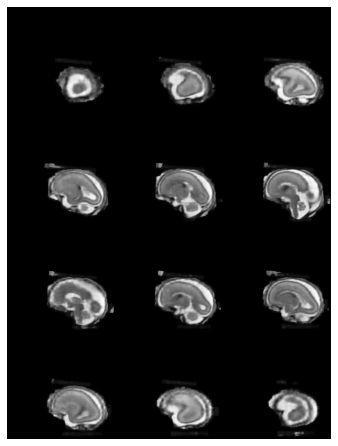

In [4]:
ants.plot(ants_fixed1)

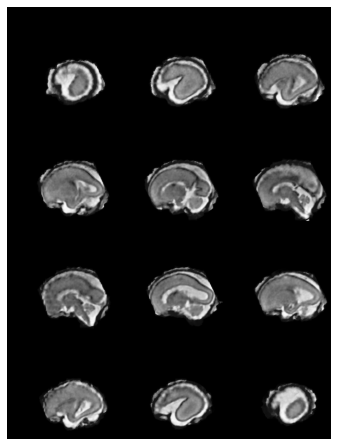

In [5]:
ants.plot(ants_moving)

In [48]:
ants_moving_reoriented = ants.reorient_image2(ants_moving,orientation='LPI')
print(ants_moving_reoriented)

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (135, 189, 155)
	 Spacing    : (0.8, 0.8, 0.8)
	 Origin     : (53.5999, 75.1999, -61.5999)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]



In [6]:
ants_affinereg_tfm = ants.registration(fixed=ants_fixed1,moving=ants_moving,
                                       aff_metric='GC',type_of_transform='Affine',
                                      outprefix='sub-036')
ants_affinereg_moving = ants_affinereg_tfm['warpedmovout']

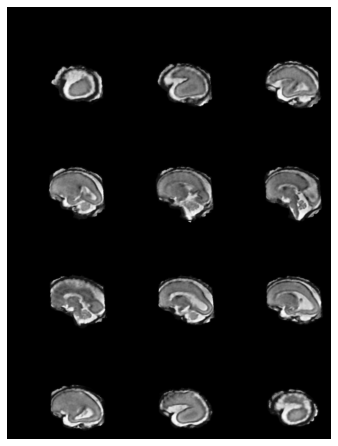

In [7]:
ants.plot(ants_affinereg_moving)

In [8]:
np.array(ants_affinereg_moving.shape)/16

array([16., 16., 16.])

In [9]:
np_img_fxd = ants_fixed1.numpy()
np_img_moving = ants_affinereg_moving.numpy()
np_img_fxd.shape,np_img_moving.shape

((256, 256, 256), (256, 256, 256))

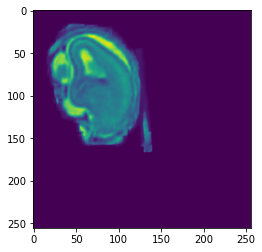

In [9]:
plt.imshow(np_img_fxd[50,:,:])

In [23]:
# np_in = np.stack([np_img_fxd[np.newaxis,...,np.newaxis],np_img_moving[...,np.newaxis]],axis=-1)
torch_fxd = torch.from_numpy(np_img_fxd[np.newaxis,np.newaxis, 50:114,...]).float()
torch_mov = torch.from_numpy(np_img_moving[np.newaxis,np.newaxis,50:114,...]).float()
torch_fxd.shape,torch_mov.shape

(torch.Size([1, 1, 64, 256, 256]), torch.Size([1, 1, 64, 256, 256]))

In [10]:
seg_fixed = ants.image_read('../feta_2.2/sub-036/anat/sub-036_rec-mial_dseg.nii.gz')
seg_moving = ants.image_read('../feta_2.2/sub-037/anat/sub-037_rec-mial_dseg.nii.gz')

In [11]:
seg_affine_reg_moving  = ants.apply_transforms(fixed=seg_fixed,
                                     moving=seg_moving,
                                     transformlist=['sub-0360GenericAffine.mat'],
                                     interpolator='nearestNeighbor'
                                    )

In [15]:
seg_affine_reg_moving

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 256)
	 Spacing    : (0.4688, 0.4688, 0.4688)
	 Origin     : (31.4982, 42.3328, -24.2942)
	 Direction  : [-9.980e-01  6.240e-02 -5.500e-03 -6.240e-02 -9.981e-01  0.000e+00
 -5.500e-03  3.000e-04  1.000e+00]

In [16]:
np_seg_fxd = seg_fixed.numpy()
np_seg_mov = seg_moving.numpy()
np_seg_aff_mov = seg_affine_reg_moving.numpy()

In [17]:
mean_dice_score(np_seg_fxd[50:114,...],np_seg_mov[50:114,...],[1,2,3,4,5,6,7])

/tmp/ipykernel_569535/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_569535/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_569535/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

0.2657457562581119

In [18]:
mean_dice_score(np_seg_fxd[50:114,...],np_seg_aff_mov[50:114,...],[1,2,3,4,5,6,7])

/tmp/ipykernel_569535/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_569535/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_569535/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

0.7077517909774167

In [38]:
torch_seg_fxd = torch.from_numpy(np_seg_fxd[np.newaxis,np.newaxis, 50:114,...]).float()
torch_seg_mov = torch.from_numpy(np_seg_aff_mov[np.newaxis,np.newaxis,50:114,...]).float()
torch_seg_fxd.shape,torch_seg_mov.shape

(torch.Size([1, 1, 64, 256, 256]), torch.Size([1, 1, 64, 256, 256]))

In [2]:

# for label in range(1,8):
#     score = jaccard(np_seg_fxd[50:114,...],np_seg_mov[50:114,...],label)
#     after_score = jaccard(np_seg_fxd[50:114,...],np_seg_aff_mov[50:114,...],label)
#     print(f'{struct_list[label]}:before: {score:.04} after : {after_score: 0.04}')

### Voxelmorph Registration

In [2]:
import torch
import os 
import time
# import voxelmorph with pytorch backend
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm 

2022-07-17 17:43:33.672121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
struct_list = {0: 'Background and Non-Brain',
                1: 'Extra-axial CSF',
                2: 'Gray Matter and developing cortical plate',
                3: 'White matter and subplate',
                4: 'Lateral ventricles',
                5: 'Cerebellum',
                6: 'Thalamus and putamen',
                7: 'Brainstem',
              }

In [4]:
ndim = 1
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# vol_shape = torch_fxd.shape[1:-1]
vol_shape = (64,256,256)
device = 'cuda:0'

vxm_model = vxm.networks.VxmDense(vol_shape,nb_features, int_steps=0).to(device)

warp_model = vxm.layers.SpatialTransformer(vol_shape,mode='nearest').to(device)
warp_model.requires_grad_ =True


/home/tanvi/.conda/envs/hbpenv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)



In [8]:
(256-64)//2

96

In [6]:
# vxm_model.load('feta01_dicelossweights/inc_dice0010.pt',device=device)

In [5]:
lr = 0.001
optimizer = torch.optim.Adam(vxm_model.parameters(), lr=lr)
image_loss_func = vxm.losses.NCC().loss
smooth_loss = vxm.losses.Grad('l2').loss
dice_loss = vxm.losses.Dice().loss
losses = [image_loss_func, smooth_loss]
weights = [1,0.2]

In [6]:
def train(model, optimizer,train_generator,batch_size):
    
    num_epochs = 20
    steps_per_epoch = 30
    model_dir = ''
    start = 1
#     dice_loss = DiceLoss()
    total_loss_curve = []
    best_loss = 1000
    for epoch in tqdm(range(num_epochs)):

        epoch_loss = []
        epoch_total_loss = []
        epoch_step_time = []
        
        for steps in range(steps_per_epoch):
            
            step_start_time = time.time()
            if start> 70-batch_size-1:
                start = 1
#             inputs, y_true,seg_vols = next(train_generator)
            inputs,y_true,seg_vols = train_generator(start)
            start +=batch_size
            y_pred = model(*inputs)           
            
            # calculate total loss
            loss = 0
            loss_list = []
            for n, loss_function in enumerate(losses):
                curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
                loss_list.append(curr_loss.item())
                loss += curr_loss

            #dice-loss 
            warped_seg = model.transformer(seg_vols[0],y_pred[1])
            
            gt = seg_vols[1]
            for label in range(1,8):
                w = (gt==label).sum()/(gt.shape[0]*gt.shape[-3]*gt.shape[-2]*gt.shape[-1])
                loss +=dice_loss(gt*(gt==label),warped_seg*(warped_seg == label))/w
#             loss += dice_loss(,warped_seg)
            epoch_loss.append(loss_list)
            epoch_total_loss.append(loss.item())

            # backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get compute time
            epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
        epoch_info = 'Epoch %d/%d' % (epoch + 1, num_epochs)
        time_info = '%.4f sec/step' % np.mean(epoch_step_time)
        losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
        loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
        print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
        total_loss_curve.append(np.mean(epoch_total_loss))
        
            # save model checkpoint
        if np.mean(epoch_total_loss) < best_loss:
            best_loss = np.mean(epoch_total_loss)
            model.save(os.path.join(model_dir, 'dice_loss_128_%d.pt' % epoch))
    return total_loss_curve

In [7]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [47]:
class DiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceLoss, self).__init__()
        
    def forward(self,gt,pred):
        num_classes = 7
        eps = 1e-5
        shape = (0,1,2,3,4)
        for label in range(1,num_classes+1):
            gt_label = gt== label
            pred_label = pred == label
            
            num = (gt_label*pred_label).sum(axis=shape)
            den = (gt_label.sum(axis=shape) + pred_label.sum(axis=shape) + eps)
            dice_loss = num/den
        return torch.mean(dice_loss)

In [3]:
ants_dir = 'affine_reg/'
def read_ants(filename):
    try:
        ants_img = ants.image_read(filename)
    except:
        filename = filename.replace('irtk','mial')
        ants_img = ants.image_read(filename) 
    
    ants_seg = ants.image_read(filename.replace('T2w','dseg'))
    return tuple([ants_img,ants_seg])

def normalize(img):
    return (img- img.min())/(img.max() - img.min())

def ants_to_numpy(ants_img,norm=False):
    img_np = ants_img.numpy()
    if norm:
        img_np = normalize(img_np)
    img_np = img_np[50:114,:,:]
    return img_np[np.newaxis,...]
    
def apply_tfm(fixed,moving,tfm_path,interp):
    ants_warped = ants.apply_transforms(fixed= fixed,
                                 moving= moving,
                                 transformlist= tfm_path,
                                 interpolator= interp
                                )
    return ants_warped
    
def load_volfile(filename, reference):

    ants_img, ants_seg = read_ants(filename)
    ants_ref, seg_ref = read_ants(reference)
    
    tfm_path = ants_dir+ filename.split('/')[2]+ '0GenericAffine.mat'
    
    ants_ref = apply_tfm(ants_img, ants_ref,tfm_path,'linear')
    seg_ref = apply_tfm(ants_seg, seg_ref,tfm_path,'nearestNeighbor')
 
    return (ants_to_numpy(ants_ref,True),ants_to_numpy(seg_ref), ants_to_numpy(ants_img,True),ants_to_numpy(ants_seg))

def numpy_to_torch(img_list,device):
    imgs_np = np.concatenate(img_list, axis=0)
    imgs_torch = torch.from_numpy(imgs_np).float()
    return imgs_torch.to(device)

def volgen(vol_names,start,batch_size,reference,device):
    
    while True:

#         indices = np.random.randint(len(vol_names), size=batch_size)
        indices = np.arange(start,start+ batch_size,dtype=np.uint8)
        img_segs = [load_volfile(vol_names[i], reference) for i in indices]
        
        volumes = {'scan1' : [],
                  'seg1': [],
                  'scan2': [],
                  'seg2': []
                  }
        for i,key in enumerate(volumes.keys()):
            volumes[key].append([img_segs[x][i] for x in range(len(img_segs))])

        yield(tuple([numpy_to_torch(volumes[key],device) for key in volumes.keys()]))
        
def vxm_data_generator(vol_names,start, batch_size, reference, device):
    
    gen = volgen(vol_names,batch_size,reference,device) 
    
    while True:

        scan1, seg1, scan2, seg2 = next(gen)
        
        shape = scan1.shape[2:]
        zeros = torch.zeros((batch_size, len(shape), *shape)).to(device)
    
        invols = [scan1, scan2]
        outvols = [scan2, zeros] 
        seg_vols = [seg1, seg2]
        
        yield (invols, outvols,seg_vols)

In [4]:
def vxm_start_generator(start,vol_names, batch_size, reference, device):
    
    indices = np.arange(start,start+ batch_size,dtype=np.uint8) 
    img_segs = [load_volfile(vol_names[i], reference) for i in indices]
    volumes = {'scan1' : [],
          'seg1': [],
          'scan2': [],
          'seg2': []
          }
    for i,key in enumerate(volumes.keys()):
        volumes[key].append([img_segs[x][i] for x in range(len(img_segs))])

    scan1, seg1, scan2, seg2 = tuple([numpy_to_torch(volumes[key],device) for key in volumes.keys()])

    shape = scan1.shape[2:]
    zeros = torch.zeros((batch_size, len(shape), *shape)).to(device)

    invols = [scan1, scan2]
    outvols = [scan2, zeros] 
    seg_vols = [seg1, seg2]
        
    return (invols, outvols,seg_vols)

In [2]:
df = pd.read_table('../feta_2.2/participants.tsv')
normal_df = df[df['Pathology']=='Neurotypical']
valid_indices = [int(idx.split('-')[-1]) for idx in normal_df['participant_id']]
vol_names_normal = [ f'../feta_2.2/sub-{idx:03}/anat/sub-{idx:03}_rec-irtk_T2w.nii.gz' for idx in valid_indices]
reference = vol_names_normal[0]
# vol_names = vol_names[1:]

In [3]:
patho_df = df[df['Pathology']=='Pathological']
valid_indices = [int(idx.split('-')[-1]) for idx in patho_df['participant_id']]
vol_names_patho = [ f'../feta_2.2/sub-{idx:03}/anat/sub-{idx:03}_rec-irtk_T2w.nii.gz' for idx in valid_indices]
len(vol_names_patho),len(vol_names_normal)

(49, 31)

In [5]:
vol_names_normal[:30]

['../feta_2.2/sub-026/anat/sub-026_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-027/anat/sub-027_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-028/anat/sub-028_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-029/anat/sub-029_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-030/anat/sub-030_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-031/anat/sub-031_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-032/anat/sub-032_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-033/anat/sub-033_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-034/anat/sub-034_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-035/anat/sub-035_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-036/anat/sub-036_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-037/anat/sub-037_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-038/anat/sub-038_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-039/anat/sub-039_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-040/anat/sub-040_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-041/anat/sub-041_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-044/anat/sub-044_rec-irtk_T2w.nii.gz',
 '../feta_2.2/sub-045/anat/sub-

In [52]:
ants_ref = ants.image_read(reference.replace('irtk','mial'))
npa = ants_ref.numpy()
npa[96:-96].shape

(64, 256, 256)

In [53]:
256-96

160

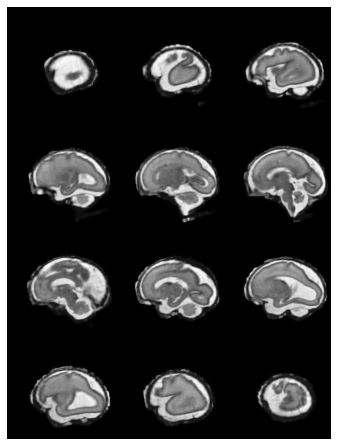

In [54]:
ants.plot(ants_ref)

In [55]:
# # ants_ref = ants.image_read(reference)
# for filename in tqdm(vol_names):

#     try:
#         ants_img = ants.image_read(filename)
#     except:
#         filename = filename.replace('irtk','mial')
#         ants_img = ants.image_read(filename) 
    
#     ants_affinereg_tfm = ants.registration(fixed=ants_img,moving=ants_ref,
#                                            aff_metric='GC',type_of_transform='Affine',
#                                           outprefix= ants_dir + filename.split('/')[2])

In [7]:
vol_names = [ f'../feta_2.2/sub-{idx:03}/anat/sub-{idx:03}_rec-irtk_T2w.nii.gz' for idx in range(1,81)]

In [16]:
for i in tqdm(range(len(vol_names_normal))):
    filename = vol_names_normal[i]
    _,_, img,seg = load_volfile(filename,reference)
    np.save('cropped_volumes/'+ filename.split('/')[2] + '.npy',img.squeeze())
    np.save('label_maps/'+ filename.split('/')[2] + '.npy',seg.squeeze().astype(np.uint8))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:58<00:00,  1.89s/it]


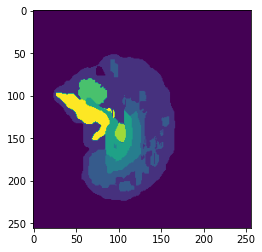

In [21]:
plt.imshow(seg[50])

In [22]:
seg.shape,seg.dtype

((64, 256, 256), dtype('uint8'))

In [19]:
img = np.load('cropped_volumes/'+ filename.split('/')[2] + '.npy')
seg = np.load('label_maps/'+ filename.split('/')[2] + '.npy')

In [11]:
filename.split('/')[2] + '.npy'

'sub-030.npy'

In [14]:
batch_size = 1
start_gen = partial(vxm_start_generator,vol_names=vol_names,batch_size=batch_size,reference=reference,device=device)
invols,out_vols,seg_vols = start_gen(13)

In [15]:
[seg_vols[i].shape for i in range(len(seg_vols))]

[torch.Size([1, 1, 64, 256, 256]), torch.Size([1, 1, 64, 256, 256])]

In [42]:
out = vxm_model(*invols)

In [27]:
losses[0](out[0],out_vols[0])

tensor(-0.2155, device='cuda:0', grad_fn=<NegBackward0>)

In [59]:
gt = seg_vols[1]
(gt==2).sum()/(gt.shape[0]*gt.shape[-3]*gt.shape[-2]*gt.shape[-1])

tensor(0.0747, device='cuda:0')

In [28]:
in2 = seg_vols[1]
dice_loss(in2*(in2==2.),x*(x ==2.))

tensor(-0.8314, device='cuda:0', grad_fn=<NegBackward0>)

In [26]:
np_seg_fxd = seg_vols[1][0].cpu().detach().numpy().squeeze()
np_seg_vxm = x.cpu()[0].detach().numpy().squeeze()
afters = []
for label in range(1,8):
    dice = dice_score(np_seg_fxd,np_seg_vxm,label)
    jc = jaccard(np_seg_fxd,np_seg_vxm,label)
    hd = haussdorff_distance(np_seg_fxd, np_seg_vxm, label,
                       percentile= 95, spacing_mm=[0.5, 0.5, 0.5])
    afters.append([dice,jc,hd])
    print(f'{struct_list[label]}: dice: {dice: .04}, jc: {jc:.04}, hd: {hd: 0.04}')

/tmp/ipykernel_869793/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_869793/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_869793/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

Extra-axial CSF: dice:  0.7812, jc: 0.641, hd:  2.5
Gray Matter and developing cortical plate: dice:  0.5922, jc: 0.4207, hd:  1.5
White matter and subplate: dice:  0.8459, jc: 0.733, hd:  1.871
Lateral ventricles: dice:  0.8391, jc: 0.7227, hd:  2.693
Cerebellum: dice:  0.8689, jc: 0.7682, hd:  1.414
Thalamus and putamen: dice:  0.8037, jc: 0.6718, hd:  2.828
Brainstem: dice:  0.6447, jc: 0.4757, hd:  5.5


In [34]:
print([afters[x][0] - befores[x][0] for x in range(len(befores))])
print([-afters[x][2] + befores[x][2] for x in range(len(befores))])

[-0.0388980889891114, -0.10197031255675099, -0.014145021636401411, 0.007256054940921852, -0.04327935050712273, -0.032270491745210794, -0.001492568398580696]
[0.06155281280883029, -0.2504916501726717, 0.05976753075081209, 0.05392003243379495, -0.30277563773199456, -0.2718949647651967, 0.5]


In [ ]:
Extra-axial CSF: dice:  0.6953, jc: 0.533, hd:  2.915
Gray Matter and developing cortical plate: dice:  0.3453, jc: 0.2087, hd:  3.041
White matter and subplate: dice:  0.7952, jc: 0.66, hd:  3.354
Lateral ventricles: dice:  0.4513, jc: 0.2914, hd:  5.148
Cerebellum: dice:  0.6981, jc: 0.5362, hd:  4.031
Thalamus and putamen: dice:  0.8128, jc: 0.6846, hd:  2.739
Brainstem: dice:  0.7399, jc: 0.5872, hd:  5.874

In [33]:
np_seg_fxd = seg_vols[1][0].cpu().detach().numpy().squeeze()
np_seg_mov = seg_vols[0][0].cpu().detach().numpy().squeeze()
total_dice = 0
befores = []
for label in range(1,8):
    dice = dice_score(np_seg_fxd,np_seg_mov,label)
    total_dice += dice
    jc = jaccard(np_seg_fxd,np_seg_mov,label)
    hd = haussdorff_distance(np_seg_fxd, np_seg_mov, label,
                       percentile= 95, spacing_mm=[0.5, 0.5, 0.5])
    befores.append([dice,jc,hd])
    print(f'{struct_list[label]}: dice: {dice: .04}, jc: {jc:.04}, hd: {hd: 0.04}')

/tmp/ipykernel_881102/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_881102/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_881102/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

Extra-axial CSF: dice:  0.7458, jc: 0.5946, hd:  2.062
Gray Matter and developing cortical plate: dice:  0.4481, jc: 0.2887, hd:  1.871
White matter and subplate: dice:  0.8011, jc: 0.6682, hd:  2.121
Lateral ventricles: dice:  0.6985, jc: 0.5367, hd:  2.345
Cerebellum: dice:  0.8511, jc: 0.7407, hd:  1.5
Thalamus and putamen: dice:  0.7856, jc: 0.647, hd:  3.082
Brainstem: dice:  0.6207, jc: 0.45, hd:  5.0


In [22]:
invols[0][1].max(),invols[0][1].min()

(tensor(0.9596, device='cuda:0'), tensor(0., device='cuda:0'))

In [48]:
np_seg_fxd.max(),np_seg_fxd.min()

(0.9572108, 0.0)

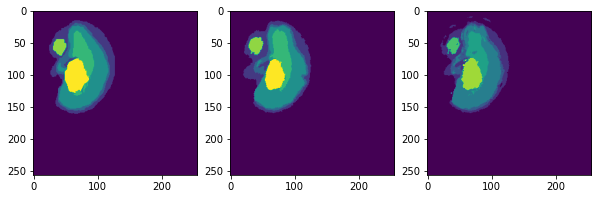

In [28]:
plt.figure(figsize=(10,10))
# np_seg_fxd = invols[1][0].cpu().detach().numpy().squeeze()
# # np_seg_fxd = (np_seg_fxd-np_seg_fxd.min())/(np_seg_fxd.max() - np_seg_fxd.min())
# np_seg_mov = invols[0][0].cpu().detach().numpy().squeeze()

plt.subplot(131).imshow(np_seg_fxd[35,:,:])
plt.subplot(132).imshow(np_seg_mov[35,:,:])
plt.subplot(133).imshow(np_seg_vxm[35,:,:])

In [47]:
vxm_model.load('inc_dice0010.pt',device)

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (mai

In [48]:
batch_size = 1
afters = []
for batch_idx in tqdm(range(len(vol_names))):
    inputs,y_true,seg_vols = start_gen(batch_idx)
            
    y_pred = vxm_model(*inputs)  
    warped_seg = warp_model(seg_vols[0],y_pred[1])
    
#     dice_metric = 1 - loss_function(test_outputs,test_labels).item() 

    np_seg_fxd = seg_vols[1][0].cpu().detach().numpy().squeeze()
    np_seg_vxm = warped_seg.cpu()[0].detach().numpy().squeeze()
    
    for label in range(1,8):
        dice = dice_score(np_seg_fxd,np_seg_vxm,label)
        jc = jaccard(np_seg_fxd,np_seg_vxm,label)
        hd = haussdorff_distance(np_seg_fxd, np_seg_vxm, label,
                           percentile= 95, spacing_mm=[0.5, 0.5, 0.5])
        afters.append([dice,jc,hd])
#         print(f'{struct_list[label]}: dice: {dice: .04}, jc: {jc:.04}, hd: {hd: 0.04}')

  0%|                                                                                                                                   | 0/80 [00:00<?, ?it/s]/tmp/ipykernel_968988/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_968988/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_9689

In [53]:
avg_dsc = []
avg_jc = []
avg_hd = []
for i in range(0,len(afters),7):
    mean_arr = np.mean(afters[i:i+7],axis=0)
    avg_dsc.append(mean_arr[0])
    avg_jc.append(mean_arr[1])
    avg_hd.append(mean_arr[2])

In [54]:
np.sort(avg_dsc)

array([0.16023472, 0.22199188, 0.22975307, 0.3031042 , 0.31711606,
       0.32408945, 0.3343991 , 0.35918811, 0.36667304, 0.38443634,
       0.38929134, 0.39154298, 0.39570196, 0.39724933, 0.40300713,
       0.41041568, 0.41276355, 0.41686703, 0.4275837 , 0.43031488,
       0.44560424, 0.446799  , 0.46021994, 0.4924319 , 0.49530203,
       0.49986563, 0.5055663 , 0.52614788, 0.52933858, 0.53020399,
       0.53337147, 0.54489691, 0.55500673, 0.56006699, 0.56063421,
       0.56823668, 0.56848738, 0.57876741, 0.58711869, 0.5976705 ,
       0.62617665, 0.62633638, 0.62961852, 0.64440511, 0.6475703 ,
       0.64875333, 0.65867806, 0.65972649, 0.66114098, 0.66365994,
       0.66808033, 0.66858563, 0.67354292, 0.68141499, 0.68196507,
       0.68559815, 0.68564164, 0.68662389, 0.68780577, 0.69132801,
       0.69658325, 0.69750966, 0.69820937, 0.69849237, 0.70266544,
       0.70403305, 0.70696291, 0.71023849, 0.71070556, 0.71337046,
       0.71601251, 0.71669991, 0.72501171, 0.72720757, 0.72917

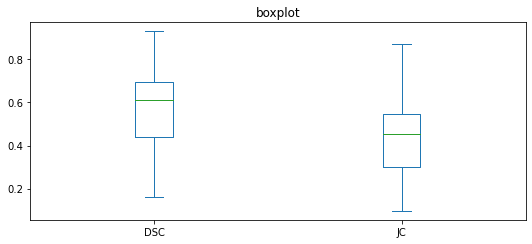

In [51]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame({"DSC": avg_dsc, "JC": avg_jc})

# Plot the dataframe
ax = data[['DSC', 'JC']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

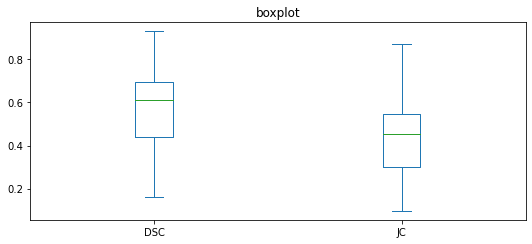

In [46]:
#combined training
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame({"DSC": avg_dsc, "JC": avg_jc})

# Plot the dataframe
ax = data[['DSC', 'JC']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

In [33]:
np_seg_fxd = seg_vols[1][0].cpu().detach().numpy().squeeze()
np_seg_vxm = warped_seg.cpu()[0].detach().numpy().squeeze()
afters = []
for label in range(1,8):
    dice = dice_score(np_seg_fxd,np_seg_vxm,label)
    jc = jaccard(np_seg_fxd,np_seg_vxm,label)
    hd = haussdorff_distance(np_seg_fxd, np_seg_vxm, label,
                       percentile= 95, spacing_mm=[0.5, 0.5, 0.5])
    afters.append([dice,jc,hd])
    print(f'{struct_list[label]}: dice: {dice: .04}, jc: {jc:.04}, hd: {hd: 0.04}')

/tmp/ipykernel_963712/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_963712/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_963712/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

Extra-axial CSF: dice:  0.658, jc: 0.4904, hd:  3.606
Gray Matter and developing cortical plate: dice:  0.3116, jc: 0.1846, hd:  4.031
White matter and subplate: dice:  0.7667, jc: 0.6217, hd:  3.674
Lateral ventricles: dice:  0.5411, jc: 0.3709, hd:  3.742
Cerebellum: dice:  0.5009, jc: 0.3341, hd:  3.64
Thalamus and putamen: dice:  0.6272, jc: 0.4569, hd:  5.099
Brainstem: dice:  0.4776, jc: 0.3137, hd:  7.089


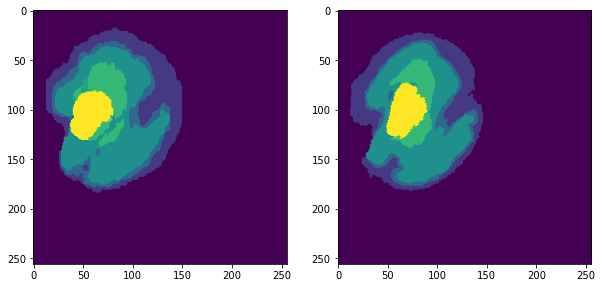

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(121).imshow(np_seg_fxd[35,:,:])
plt.subplot(122).imshow(np_seg_vxm[35,:,:])

In [58]:
np.unique(np_seg_fxd.astype(np.uint8))

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [60]:
np_seg_fxd = seg_vols[0][0].cpu().detach().numpy().squeeze()
np.save('label_maps/sub026.npy',np_seg_fxd.astype(np.uint8))

In [38]:
import nrrd 

nrrd.write('tru_label_sub11.nrrd', np_seg_fxd, index_order='C')

In [20]:
torch.cuda.empty_cache()

In [16]:
train_loss = train(vxm_model,optimizer,start_gen,1)

  0%|                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - 5.8052 sec/step - loss: -2.0667e+03  (-1.0639e-01, 3.6120e-05)


  5%|██████                                                                                                                    | 1/20 [02:54<55:16, 174.56s/it]

Epoch 2/20 - 5.8875 sec/step - loss: -1.4606e+03  (-1.1322e-01, 1.9902e-04)


 10%|████████████▏                                                                                                             | 2/20 [05:51<52:43, 175.77s/it]

Epoch 3/20 - 5.8411 sec/step - loss: -2.6076e+03  (-8.6774e-02, 8.3168e-05)


 15%|██████████████████▎                                                                                                       | 3/20 [08:46<49:47, 175.71s/it]

Epoch 4/20 - 5.8531 sec/step - loss: -1.5798e+03  (-1.2832e-01, 2.8406e-04)


 20%|████████████████████████▍                                                                                                 | 4/20 [11:42<46:50, 175.66s/it]

Epoch 5/20 - 5.8674 sec/step - loss: -2.0855e+03  (-9.6771e-02, 1.1654e-04)


 25%|██████████████████████████████▌                                                                                           | 5/20 [14:38<43:56, 175.79s/it]

Epoch 6/20 - 5.8252 sec/step - loss: -1.7361e+03  (-1.1825e-01, 5.7297e-04)


 30%|████████████████████████████████████▌                                                                                     | 6/20 [17:33<40:56, 175.44s/it]

Epoch 7/20 - 5.8915 sec/step - loss: -1.5262e+03  (-1.0336e-01, 8.8588e-04)


 35%|██████████████████████████████████████████▋                                                                               | 7/20 [20:29<38:06, 175.87s/it]

Epoch 8/20 - 5.8137 sec/step - loss: -2.1898e+03  (-1.2310e-01, 8.1714e-04)


 40%|████████████████████████████████████████████████▊                                                                         | 8/20 [23:24<35:04, 175.40s/it]

Epoch 9/20 - 5.9052 sec/step - loss: -1.6686e+03  (-1.1095e-01, 1.9513e-03)


 45%|██████████████████████████████████████████████████████▉                                                                   | 9/20 [26:21<32:15, 175.95s/it]

Epoch 10/20 - 5.8171 sec/step - loss: -2.1506e+03  (-1.1795e-01, 1.7087e-03)


 50%|████████████████████████████████████████████████████████████▌                                                            | 10/20 [29:16<29:15, 175.51s/it]

Epoch 11/20 - 5.8712 sec/step - loss: -1.5704e+03  (-1.2333e-01, 2.4740e-03)


 55%|██████████████████████████████████████████████████████████████████▌                                                      | 11/20 [32:12<26:21, 175.70s/it]

Epoch 12/20 - 5.8501 sec/step - loss: -2.3775e+03  (-1.0913e-01, 3.1053e-03)


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 12/20 [35:07<23:25, 175.64s/it]

Epoch 13/20 - 5.8453 sec/step - loss: -1.5370e+03  (-1.4649e-01, 2.6755e-03)


 65%|██████████████████████████████████████████████████████████████████████████████▋                                          | 13/20 [38:03<20:28, 175.56s/it]

Epoch 14/20 - 5.8795 sec/step - loss: -2.1609e+03  (-1.3087e-01, 5.4468e-03)


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 14/20 [40:59<17:34, 175.81s/it]

Epoch 15/20 - 5.8271 sec/step - loss: -1.7965e+03  (-1.5435e-01, 3.7626e-03)


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 15/20 [43:54<14:37, 175.51s/it]

Epoch 16/20 - 5.8993 sec/step - loss: -1.6073e+03  (-1.5662e-01, 8.8696e-03)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16/20 [46:51<11:43, 175.95s/it]

Epoch 17/20 - 5.8163 sec/step - loss: -2.2125e+03  (-1.6379e-01, 6.4870e-03)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17/20 [49:45<08:46, 175.51s/it]

Epoch 18/20 - 5.9077 sec/step - loss: -1.7212e+03  (-1.6885e-01, 1.3417e-02)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 18/20 [52:42<05:52, 176.03s/it]

Epoch 19/20 - 5.8298 sec/step - loss: -2.1599e+03  (-1.1687e-01, 4.4196e-03)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 19/20 [55:37<02:55, 175.69s/it]

Epoch 20/20 - 5.8680 sec/step - loss: -1.6091e+03  (-1.5451e-01, 6.0245e-03)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [58:33<00:00, 175.69s/it]


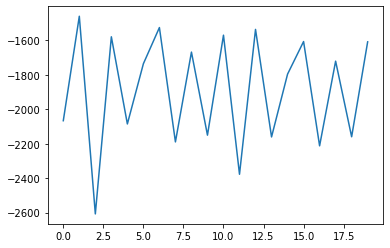

In [17]:
plt.plot(train_loss)

In [12]:
def train(model,warp_model, optimizer,train_generator,batch_size):
    
    num_epochs = 20
    steps_per_epoch = 30
    model_dir = ''
    start = 1
#     dice_loss = DiceLoss()
    total_loss_curve = []
    for epoch in tqdm(range(num_epochs)):

    # save model checkpoint
        if epoch % 5 == 0:
            model.save(os.path.join(model_dir, 'inc_dice%04d.pt' % epoch))

        epoch_loss = []
        epoch_total_loss = []
        epoch_step_time = []
        
        for steps in range(steps_per_epoch):
            
            step_start_time = time.time()
            if start> 30-batch_size-1:
                start = 1
#             inputs, y_true,seg_vols = next(train_generator)
            inputs,y_true,seg_vols = train_generator(start)
            start +=batch_size
            y_pred = model(*seg_vols)           
            
            # calculate total loss
            loss = 0
            loss_list = []

            #dice-loss 
            warped_seg = warp_model(inputs[0],y_pred[1])
            loss += image_loss_func(inputs[1],warped_seg)
            loss_list.append(loss.item())
            phi_loss = 0.2*smooth_loss(out_vols[1],y_pred[1])
            loss += phi_loss
            loss_list.append(phi_loss.item())
            
            gt = seg_vols[1]
            for label in range(1,8):
                w = (gt==label).sum()/(gt.shape[0]*gt.shape[-3]*gt.shape[-2]*gt.shape[-1])
                loss +=dice_loss(gt*(gt==label),y_pred[0]*(y_pred[0] == label))/w
#             loss += dice_loss(,warped_seg)
            epoch_loss.append(loss_list)
            epoch_total_loss.append(loss.item())

            # backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get compute time
            epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
        epoch_info = 'Epoch %d/%d' % (epoch + 1, num_epochs)
        time_info = '%.4f sec/step' % np.mean(epoch_step_time)
        losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
        loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
        print(' - '.join((epoch_info, time_info, loss_info)), flush=True)
        total_loss_curve.append(np.mean(epoch_total_loss))
    return total_loss_curve

In [13]:
train_loss = train(vxm_model,warp_model,optimizer,start_gen,2)

  0%|                                                                                                                                   | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - 5.8206 sec/step - loss: -1.4340e+03  (-1.2763e-01, 3.8853e-05)


  5%|██████                                                                                                                    | 1/20 [02:54<55:18, 174.64s/it]

Epoch 2/20 - 5.8222 sec/step - loss: -1.4174e+03  (-1.2926e-01, 8.3244e-05)


 10%|████████████▏                                                                                                             | 2/20 [05:49<52:23, 174.66s/it]

Epoch 3/20 - 5.8117 sec/step - loss: -1.3340e+03  (-1.2263e-01, 2.2778e-04)


 15%|██████████████████▎                                                                                                       | 3/20 [08:43<49:26, 174.52s/it]

Epoch 4/20 - 5.8186 sec/step - loss: -1.3331e+03  (-1.2242e-01, 9.8616e-04)


 20%|████████████████████████▍                                                                                                 | 4/20 [11:38<46:32, 174.53s/it]

Epoch 5/20 - 5.8254 sec/step - loss: -1.5143e+03  (-1.2498e-01, 4.2550e-05)


 25%|██████████████████████████████▌                                                                                           | 5/20 [14:32<43:39, 174.62s/it]

Epoch 6/20 - 5.8187 sec/step - loss: -1.4518e+03  (-1.2622e-01, 1.3706e-05)


 30%|████████████████████████████████████▌                                                                                     | 6/20 [17:27<40:46, 174.73s/it]

Epoch 7/20 - 5.8255 sec/step - loss: -1.6145e+03  (-1.2858e-01, 3.6849e-06)


 35%|██████████████████████████████████████████▋                                                                               | 7/20 [20:22<37:51, 174.74s/it]

Epoch 8/20 - 5.8232 sec/step - loss: -1.7203e+03  (-1.2901e-01, 1.9219e-06)


 40%|████████████████████████████████████████████████▊                                                                         | 8/20 [23:17<34:56, 174.73s/it]

Epoch 9/20 - 5.8204 sec/step - loss: -1.6253e+03  (-1.3068e-01, 1.3698e-05)


 45%|██████████████████████████████████████████████████████▉                                                                   | 9/20 [26:12<32:01, 174.69s/it]

Epoch 10/20 - 5.8220 sec/step - loss: -1.3552e+03  (-1.2475e-01, 2.3093e-04)


 50%|████████████████████████████████████████████████████████████▌                                                            | 10/20 [29:06<29:06, 174.68s/it]

Epoch 11/20 - 5.8239 sec/step - loss: -5.5565e+02  (-7.5544e-02, 6.7959e-01)


 55%|██████████████████████████████████████████████████████████████████▌                                                      | 11/20 [32:01<26:13, 174.82s/it]

Epoch 12/20 - 5.8319 sec/step - loss: 1.4402e+01  (-1.4738e-02, 3.7040e+01)


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 12/20 [34:56<23:18, 174.86s/it]

Epoch 13/20 - 5.8244 sec/step - loss: -2.6142e+01  (-2.6149e-02, 6.0823e-01)


 65%|██████████████████████████████████████████████████████████████████████████████▋                                          | 13/20 [37:51<20:23, 174.82s/it]

Epoch 14/20 - 5.8238 sec/step - loss: -2.1819e+02  (-5.0868e-02, 5.0810e-02)


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 14/20 [40:46<17:28, 174.79s/it]

Epoch 15/20 - 5.8208 sec/step - loss: -2.3821e+02  (-5.1265e-02, 7.4250e-02)


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 15/20 [43:40<14:33, 174.74s/it]

Epoch 16/20 - 5.8168 sec/step - loss: 7.7607e+02  (-3.1732e-03, 7.7688e+02)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16/20 [46:35<11:39, 174.79s/it]

Epoch 17/20 - 5.8249 sec/step - loss: 8.5696e+00  (-5.1517e-03, 9.0222e+00)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 17/20 [49:30<08:44, 174.78s/it]

Epoch 18/20 - 5.8287 sec/step - loss: -2.0236e+01  (-3.1593e-02, 7.0238e-01)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 18/20 [52:25<05:49, 174.80s/it]

Epoch 19/20 - 5.8295 sec/step - loss: -1.3265e+02  (-6.0033e-02, 1.4188e-01)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 19/20 [55:20<02:54, 174.83s/it]

Epoch 20/20 - 5.8277 sec/step - loss: -4.1634e+02  (-6.2028e-02, 1.1206e-01)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [58:15<00:00, 174.75s/it]


In [29]:
out = vxm_model(*seg_vols)
int2 = warp_model(invols[0],out[1])

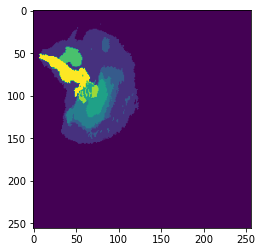

In [30]:
plt.imshow(out[0].squeeze().cpu().detach().numpy()[20])

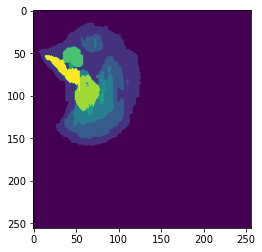

In [31]:
plt.imshow(seg_vols[1].squeeze().cpu().detach().numpy()[20])

In [32]:
np_seg_fxd = seg_vols[1].cpu().detach().numpy().squeeze()
np_seg_vxm = out[0].cpu().detach().numpy().squeeze()
afters = []
for label in range(1,8):
    dice = dice_score(np_seg_fxd,np_seg_vxm,label)
    jc = jaccard(np_seg_fxd,np_seg_vxm,label)
    hd = haussdorff_distance(np_seg_fxd, np_seg_vxm, label,
                       percentile= 95, spacing_mm=[0.5, 0.5, 0.5])
    afters.append([dice,jc,hd])
    print(f'{struct_list[label]}: dice: {dice: .04}, jc: {jc:.04}, hd: {hd: 0.04}')

/tmp/ipykernel_881102/968590266.py:212: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_881102/968590266.py:227: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/tmp/ipykernel_881102/968590266.py:229: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wil

Extra-axial CSF: dice:  0.7069, jc: 0.5467, hd:  2.0
Gray Matter and developing cortical plate: dice:  0.3461, jc: 0.2093, hd:  2.121
White matter and subplate: dice:  0.7869, jc: 0.6487, hd:  2.062
Lateral ventricles: dice:  0.7058, jc: 0.5453, hd:  2.291
Cerebellum: dice:  0.8078, jc: 0.6775, hd:  1.803
Thalamus and putamen: dice:  0.7534, jc: 0.6043, hd:  3.354
Brainstem: dice:  0.6192, jc: 0.4484, hd:  4.5


In [17]:
!nvidia-smi

Sat Jul 16 19:13:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
|  0%   47C    P8    19W / 350W |  22257MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
!kill 952215

In [35]:
torch.cuda.empty_cache()

### Evaluation metrics

In [19]:
"""Lookup tables used by surface distance metrics."""

# neighbour_code_to_normals is a lookup table.
# For every binary neighbour code
# (2x2x2 neighbourhood = 8 neighbours = 8 bits = 256 codes)
# it contains the surface normals of the triangles (called "surfel" for
# "surface element" in the following). The length of the normal
# vector encodes the surfel area.
#
# created using the marching_cube algorithm
# see e.g. https://en.wikipedia.org/wiki/Marching_cubes
# pylint: disable=line-too-long
neighbour_code_to_normals = [
    [[0, 0, 0]],
    [[0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
    [[0.125, -0.125, 0.125]],
    [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
    [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
    [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25], [-0.125, 0.125, -0.125]],
    [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
    [[0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25], [-0.125, -0.125, -0.125]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25], [0.125, -0.125, -0.125]],
    [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375], [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
    [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25], [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
    [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
    [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25]],
    [[0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
    [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125], [0.25, 0.25, -0.25]],
    [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
    [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25], [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25], [0.125, 0.125, -0.125], [-0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25], [-0.125, 0.125, -0.125], [0.125, -0.125, 0.125]],
    [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375], [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
    [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
    [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125], [-0.25, 0.25, -0.25]],
    [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
    [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0], [0.125, -0.125, 0.125]],
    [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25], [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
    [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0], [-0.25, -0.25, -0.25], [-0.125, -0.125, -0.125]],
    [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25], [-0.125, -0.125, -0.125]],
    [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
    [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0], [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
    [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0], [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0], [-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
    [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
    [[-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
    [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25], [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
    [[-0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
    [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25], [-0.125, 0.125, -0.125], [-0.125, 0.125, -0.125]],
    [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375], [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
    [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
    [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
    [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375], [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
    [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
    [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125], [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25], [-0.125, 0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
    [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375], [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
    [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
    [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25], [0.125, -0.125, -0.125]],
    [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25], [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
    [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0], [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
    [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
    [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
    [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
    [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
    [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
    [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
    [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
    [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0], [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25], [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
    [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25], [0.125, -0.125, -0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25], [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
    [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375], [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
    [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25], [-0.125, 0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125], [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
    [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
    [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375], [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
    [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
    [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375], [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
    [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25], [-0.125, 0.125, -0.125], [-0.125, 0.125, -0.125]],
    [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25], [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25], [0.125, -0.125, 0.125]],
    [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
    [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
    [[-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
    [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
    [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0], [-0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
    [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
    [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0], [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
    [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
    [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25], [-0.125, -0.125, -0.125]],
    [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0], [-0.25, -0.25, -0.25], [-0.125, -0.125, -0.125]],
    [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25], [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
    [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0], [0.125, -0.125, 0.125]],
    [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
    [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125], [-0.25, 0.25, -0.25]],
    [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
    [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
    [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375], [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
    [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25], [-0.125, 0.125, -0.125], [0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25], [0.125, 0.125, -0.125], [-0.125, -0.125, 0.125]],
    [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25], [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
    [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25], [0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
    [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125], [0.25, 0.25, -0.25]],
    [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
    [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
    [[0.125, -0.125, 0.125]],
    [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25]],
    [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
    [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25], [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
    [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375], [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
    [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
    [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25], [-0.125, -0.125, -0.125]],
    [[0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[-0.125, -0.125, 0.125], [0.125, -0.125, -0.125]],
    [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
    [[0.125, -0.125, -0.125]],
    [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
    [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125]],
    [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25], [-0.125, 0.125, -0.125]],
    [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
    [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25], [-0.125, -0.125, 0.125]],
    [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
    [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
    [[-0.125, 0.125, 0.125]],
    [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
    [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125]],
    [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
    [[0.125, -0.125, 0.125]],
    [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
    [[-0.125, -0.125, 0.125]],
    [[0.125, 0.125, 0.125]],
    [[0, 0, 0]]]
# pylint: enable=line-too-long

In [20]:
# Surface distances

def haussdorff_distance(mask_gt, mask_pred, fg_class,
                       percentile=100, spacing_mm=[0.8, 0.8, 0.8]):
    bin_mask_gt = np.squeeze(_binarize(mask_gt, fg_class=fg_class))
    bin_mask_pred = np.squeeze(_binarize(mask_pred, fg_class=fg_class))

    surface_distances = compute_surface_distances(
        bin_mask_gt, bin_mask_pred, spacing_mm)

    haussdorff_dist_value = compute_robust_hausdorff(surface_distances, percentile)

    return haussdorff_dist_value


def compute_surface_distances(mask_gt, mask_pred, spacing_mm):
    """
    Compute closest distances from all surface points to the other surface.
    Finds all surface elements "surfels" in the ground truth mask `mask_gt` and
    the predicted mask `mask_pred`, computes their area in mm^2 and the distance
    to the closest point on the other surface. It returns two sorted lists of
    distances together with the corresponding surfel areas. If one of the masks
    is empty, the corresponding lists are empty and all distances in the other
    list are `inf`.
    :param mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    :param mask_pred: 3-dim Numpy array of type bool. The predicted mask.
    :param spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
        direction.
    :return: A dict with:
    "distances_gt_to_pred": 1-dim numpy array of type float. The distances in mm
        from all ground truth surface elements to the predicted surface,
        sorted from smallest to largest.
    "distances_pred_to_gt": 1-dim numpy array of type float. The distances in mm
        from all predicted surface elements to the ground truth surface,
        sorted from smallest to largest.
    "surfel_areas_gt": 1-dim numpy array of type float. The area in mm^2 of
        the ground truth surface elements in the same order as
        distances_gt_to_pred
    "surfel_areas_pred": 1-dim numpy array of type float. The area in mm^2 of
        the predicted surface elements in the same order as
        distances_pred_to_gt
    """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(neighbour_code_to_normals[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    # compute the bounding box of the masks to trim
    # the volume to the smallest possible processing subvolume
    mask_all = mask_gt | mask_pred
    bbox_min = np.zeros(3, np.int64)
    bbox_max = np.zeros(3, np.int64)

    # max projection to the x0-axis
    proj_0 = np.max(np.max(mask_all, axis=2), axis=1)
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return {"distances_gt_to_pred": np.array([]),
                "distances_pred_to_gt": np.array([]),
                "surfel_areas_gt": np.array([]),
                "surfel_areas_pred": np.array([])}

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the x1-axis
    proj_1 = np.max(np.max(mask_all, axis=2), axis=0)
    idx_nonzero_1 = np.nonzero(proj_1)[0]
    bbox_min[1] = np.min(idx_nonzero_1)
    bbox_max[1] = np.max(idx_nonzero_1)

    # max projection to the x2-axis
    proj_2 = np.max(np.max(mask_all, axis=1), axis=0)
    idx_nonzero_2 = np.nonzero(proj_2)[0]
    bbox_min[2] = np.min(idx_nonzero_2)
    bbox_max[2] = np.max(idx_nonzero_2)

    # crop the processing subvolume.
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right and the back side. This is required to obtain the "full"
    # convolution result with the 2x2x2 kernel
    cropmask_gt = np.zeros((bbox_max - bbox_min)+2, np.uint8)
    cropmask_pred = np.zeros((bbox_max - bbox_min)+2, np.uint8)

    cropmask_gt[0:-1, 0:-1, 0:-1] = mask_gt[bbox_min[0]:bbox_max[0]+1,
                                            bbox_min[1]:bbox_max[1]+1,
                                            bbox_min[2]:bbox_max[2]+1]

    cropmask_pred[0:-1, 0:-1, 0:-1] = mask_pred[bbox_min[0]:bbox_max[0]+1,
                                                bbox_min[1]:bbox_max[1]+1,
                                                bbox_min[2]:bbox_max[2]+1]

    # compute the neighbour code (local binary pattern) for each voxel
    # the resulting arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    kernel = np.array([[[128, 64],
                          [32, 16]],
                         [[8, 4],
                          [2, 1]]])
    neighbour_code_map_gt = ndimage.filters.correlate(
        cropmask_gt.astype(np.uint8), kernel, mode="constant", cval=0)
    neighbour_code_map_pred = ndimage.filters.correlate(
        cropmask_pred.astype(np.uint8), kernel, mode="constant", cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) & (neighbour_code_map_gt != 255))
    borders_pred = ((neighbour_code_map_pred != 0) &
                    (neighbour_code_map_pred != 255))

    # compute the distance transform (closest distance of each voxel to the
    # surface voxels)
    if borders_gt.any():
        distmap_gt = ndimage.morphology.distance_transform_edt(
            ~borders_gt, sampling=spacing_mm)
    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape)

    if borders_pred.any():
        distmap_pred = ndimage.morphology.distance_transform_edt(
            ~borders_pred, sampling=spacing_mm)
    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape)

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surface_area_map_pred = neighbour_code_to_surface_area[
        neighbour_code_map_pred]

    # create a list of all surface elements with distance and area
    distances_gt_to_pred = distmap_pred[borders_gt]
    distances_pred_to_gt = distmap_gt[borders_pred]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    surfel_areas_pred = surface_area_map_pred[borders_pred]

    # sort them by distance
    if distances_gt_to_pred.shape != (0,):
        sorted_surfels_gt = np.array(
            sorted(zip(distances_gt_to_pred, surfel_areas_gt)))
        distances_gt_to_pred = sorted_surfels_gt[:, 0]
        surfel_areas_gt = sorted_surfels_gt[:, 1]

    if distances_pred_to_gt.shape != (0,):
        sorted_surfels_pred = np.array(
            sorted(zip(distances_pred_to_gt, surfel_areas_pred)))
        distances_pred_to_gt = sorted_surfels_pred[:, 0]
        surfel_areas_pred = sorted_surfels_pred[:, 1]

    return {"distances_gt_to_pred": distances_gt_to_pred,
            "distances_pred_to_gt": distances_pred_to_gt,
            "surfel_areas_gt": surfel_areas_gt,
            "surfel_areas_pred": surfel_areas_pred}


def compute_robust_hausdorff(surface_distances, percent):
    """
    Computes the robust Hausdorff distance.
    Computes the robust Hausdorff distance. "Robust", because it uses the
    `percent` percentile of the distances instead of the maximum distance. The
    percentage is computed by correctly taking the area of each surface element
    into account.
    Based on
    https://github.com/deepmind/surface-distance/blob/master/surface_distance/metrics.py
    :param surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
      "surfel_areas_gt", "surfel_areas_pred" created by
      compute_surface_distances()
    :param percent: a float value between 0 and 100.
    :return: a float value. The robust Hausdorff distance in mm.
    """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    if len(distances_gt_to_pred) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_gt = np.cumsum(surfel_areas_gt) / np.sum(surfel_areas_gt)
        idx = np.searchsorted(surfel_areas_cum_gt, percent/100.0)
        perc_distance_gt_to_pred = distances_gt_to_pred[
            min(idx, len(distances_gt_to_pred)-1)]
    else:
        perc_distance_gt_to_pred = np.Inf

    if len(distances_pred_to_gt) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_pred = (np.cumsum(surfel_areas_pred) /
                                 np.sum(surfel_areas_pred))
        idx = np.searchsorted(surfel_areas_cum_pred, percent/100.0)
        perc_distance_pred_to_gt = distances_pred_to_gt[
            min(idx, len(distances_pred_to_gt)-1)]
    else:
        perc_distance_pred_to_gt = np.Inf

    return max(perc_distance_gt_to_pred, perc_distance_pred_to_gt)

def _binarize(seg, fg_class=1):
    """
    Binarize a segmentation with label 1 for pixels/voxels the foreground class
    and label 0 for pixels/voxels the other classes.
    :param seg: int numpy array.
    :param fg_class: int; class in seg corresponding to the foreground.
    :return: binary segmentation corresponding to seg for the foreground class fg_class.
    """
    bin_seg = np.zeros_like(seg, dtype=np.bool)
    bin_seg[seg == fg_class] = True
    return bin_seg


# Basic metrics
def true_positives(seg_pred, seg_gt):
    """
    Number of True Positives
    for the predicted segmentation seg_pred
    and the ground-truth segmentation seg_gt.
    :param seg_pred: numpy bool array.
    :param seg_gt: numpy bool array.
    :return: int; number of true positives.
    """
    assert seg_pred.dtype == np.bool, "seg_1 should be of type bool, " \
                                      "found %s instead." % seg_pred.dtype
    assert seg_gt.dtype == np.bool, "seg_2 should be of type bool, " \
                                    "found %s instead." % seg_gt.dtype
    num_tp = np.sum(seg_pred * seg_gt)
    return num_tp


def false_positives(seg_pred, seg_gt):
    """
    Number of False Positives
    for the predicted segmentation seg_pred
    and the ground-truth segmentation seg_gt.
    :param seg_pred: numpy bool array.
    :param seg_gt: numpy bool array.
    :return: int; number of false positives.
    """
    assert seg_pred.dtype == np.bool, "seg_1 should be of type bool, " \
                                      "found %s instead." % seg_pred.dtype
    assert seg_gt.dtype == np.bool, "seg_2 should be of type bool, " \
                                    "found %s instead." % seg_gt.dtype
    num_fp = np.sum(seg_pred * (1 - seg_gt))
    return num_fp


def false_negatives(seg_pred, seg_gt):
    """
    Number of False Negatives
    for the predicted segmentation seg_pred
    and the ground-truth segmentation seg_gt.
    :param seg_pred: numpy bool array.
    :param seg_gt: numpy bool array.
    :return: int; number of false negatives.
    """
    assert seg_pred.dtype == np.bool, "seg_1 should be of type bool, " \
                                      "found %s instead." % seg_pred.dtype
    assert seg_gt.dtype == np.bool, "seg_2 should be of type bool, " \
                                    "found %s instead." % seg_gt.dtype
    num_fn = np.sum((1 - seg_pred) * seg_gt)
    return num_fn


def true_negatives(seg_pred, seg_gt):
    """
    Number of True Negatives
    for the predicted segmentation seg_pred
    and the ground-truth segmentation seg_gt.
    :param seg_pred: numpy bool array.
    :param seg_gt: numpy bool array.
    :return: int; number of true negatives.
    """
    assert seg_pred.dtype == np.bool, "seg_1 should be of type bool, " \
                                      "found %s instead." % seg_pred.dtype
    assert seg_gt.dtype == np.bool, "seg_2 should be of type bool, " \
                                    "found %s instead." % seg_gt.dtype
    num_tn = np.sum((1 - seg_pred) * (1 - seg_gt))
    return num_tn


# Dice scores and variants
def dice_score(seg_1, seg_2, fg_class=1):
    """
    Compute the Dice score for class fg_class
    between the segmentations seg_1 and seg_2.
    For explanation about the formula used to compute the Dice score coefficient,
    see for example:
    "Generalised Wasserstein Dice Score for Imbalanced Multi-class Segmentation
    using Holistic Convolutional Networks", L. Fidon et al, BrainLes 2017.
    :param seg_1: numpy int array.
    :param seg_2: numpy int array.
    :param fg_class: int.
    :return: float; Dice score value.
    """
    assert seg_1.shape == seg_2.shape, "seg_1 and seg_2 must have the same shape " \
                                       "to compute their dice score."
    # binarize the segmentations
    bin_seg_1 = _binarize(seg_1, fg_class=fg_class)
    bin_seg_2 = _binarize(seg_2, fg_class=fg_class)
    # compute the Dice score value
    tp = true_positives(bin_seg_1, bin_seg_2)
    fp = false_positives(bin_seg_1, bin_seg_2)
    fn = false_negatives(bin_seg_1, bin_seg_2)
    if tp + fp + fn == 0:  # empty foreground for seg_1 and seg_2
        dice_val = 1.
    else:
        dice_val = 2. * tp / (2. * tp + fp + fn)
    return dice_val


def mean_dice_score(seg_1, seg_2, labels_list=[0, 1]):
    """
    Compute the mean of the Dice scores for the labels in labels_list
    between the segmentations seg_1 and seg_2.
    :param seg_1: numpy int array.
    :param seg_2: numpy int array.
    :param labels_list: int list.
    :return:
    """
    assert len(labels_list) > 0, "the list of labels to consider for the mean dice score" \
                                 "must contain at least one label"
    dice_values = []
    for l in labels_list:
        dice = dice_score(seg_1, seg_2, fg_class=l)
        dice_values.append(dice)
    mean_dice = np.mean(dice_values)
    return mean_dice

def jaccard(seg_1, seg_2, fg_class=1):
    """
    Compute the Jaccard for class fg_class
    between the segmentations seg_1 and seg_2.
    :param seg_1: numpy int array.
    :param seg_2: numpy int array.
    :param fg_class: int.
    :return: float; Jaccard value.
    """
    assert seg_1.shape == seg_2.shape, "seg_1 and seg_2 must have the same shape " \
                                       "to compute their dice score"
    # binarize the segmentations
    bin_seg_1 = _binarize(seg_1, fg_class=fg_class)
    bin_seg_2 = _binarize(seg_2, fg_class=fg_class)
    # compute the Jaccard index value
    tp = true_positives(bin_seg_1, bin_seg_2)
    fp = false_positives(bin_seg_1, bin_seg_2)
    fn = false_negatives(bin_seg_1, bin_seg_2)
    if tp + fp + fn == 0:  # empty foreground for seg_1 and seg_2
        jaccard = 1.
    else:
        jaccard = tp / (tp + fp + fn)
    return jaccard

In [47]:
### sitk active_contours improvement

In [51]:
import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import clear_output

In [76]:
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[image_z,:,:] + alpha*moving[image_z,:,:] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def print_volume_info(vol):
    print(f'size: {vol.GetSize()}',f'Spacing: {vol.GetSpacing()}',
          f'Origin: {vol.GetOrigin()}',f'PixelType: {vol.GetPixelIDTypeAsString()}',sep='\n')
    print(f'Dimension: {vol.GetDimension()}')
    print(f'Num Components per pixel: {vol.GetNumberOfComponentsPerPixel()}')
    
def seg_eval(pred,gt):

    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(gt, pred)
    
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_filter.Execute(gt, pred)
    
    return hausdorff_distance_filter.GetHausdorffDistance(), overlap_measures_filter.GetDiceCoefficient()

In [149]:
intensity_img_np = invols[1][0,0].cpu().detach().numpy()
intensity_img_np = intensity_img_np.transpose((2,1,0))
intensity_img_sitk = sitk.GetImageFromArray(intensity_img_np)

np_seg_vxm_5 = (np_seg_vxm ==5 ).astype(np.uint8)
pred = sitk.GetImageFromArray((np_seg_vxm_5).transpose((2,1,0)))

np_seg_gt = seg_vols[0][0,0].cpu().detach().numpy()
np_seg_gt_5 = (np_seg_gt ==5 ).astype(np.uint8)
gt = sitk.GetImageFromArray(np_seg_gt_5.transpose((2,1,0)))


intensity_img_sitk.SetSpacing([0.5,0.5,0.5])
pred.SetSpacing([0.5,0.5,0.5])
gt.SetSpacing([0.5,0.5,0.5])

In [150]:
seg_eval(sitk.Cast(pred,sitk.sitkUInt8),sitk.Cast(gt,sitk.sitkUInt8))

(3.082207001484488, 0.8881868708053691)

In [151]:
print_volume_info(intensity_img_sitk)

size: (64, 256, 256)
Spacing: (0.5, 0.5, 0.5)
Origin: (0.0, 0.0, 0.0)
PixelType: 32-bit float
Dimension: 3
Num Components per pixel: 1


In [152]:
print_volume_info(pred)

size: (64, 256, 256)
Spacing: (0.5, 0.5, 0.5)
Origin: (0.0, 0.0, 0.0)
PixelType: 8-bit unsigned integer
Dimension: 3
Num Components per pixel: 1


In [153]:
interact(display_images_with_alpha, image_z=(0,intensity_img_sitk.GetSize()[0]-1), alpha=(0.0,1.0,0.05), 
         fixed = fixed(intensity_img_sitk), moving=fixed(sitk.Cast(pred,sitk.sitkFloat32)));

interactive(children=(IntSlider(value=31, description='image_z', max=63), FloatSlider(value=0.5, description='…

In [177]:
stats.GetMinimum(1)

0.2583201229572296

In [190]:
stats = sitk.LabelStatisticsImageFilter()
stats.SetGlobalDefaultCoordinateTolerance(1)
stats.Execute(intensity_img_sitk, sitk.Cast(pred,sitk.sitkUInt8))

factor = 0.2
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
# lower_threshold = 0.43
# upper_threshold = 0.63
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetCurvatureScaling(0.5)
lsFilter.SetPropagationScaling(0.5)
lsFilter.ReverseExpansionDirectionOn()

lsFilter.SetNumberOfIterations(500)
pred = sitk.Cast(pred,sitk.sitkFloat32)
ls = lsFilter.Execute(pred, intensity_img_sitk)
pred_new = ls>0
print(seg_eval(sitk.Cast(pred_new,sitk.sitkUInt8),sitk.Cast(gt,sitk.sitkUInt8)) )

interact(display_images_with_alpha, image_z=(0,intensity_img_sitk.GetSize()[0]-1), alpha=(0.0,1.0,0.05), 
         fixed = fixed(intensity_img_sitk), moving=fixed(sitk.Cast(pred_new,sitk.sitkFloat32)));

(4.847679857416329, 0.7432810859165337)


interactive(children=(IntSlider(value=31, description='image_z', max=63), FloatSlider(value=0.5, description='…

In [179]:
interact(display_images_with_alpha, image_z=(0,intensity_img_sitk.GetSize()[0]-1), alpha=(0.0,1.0,0.05), 
         fixed = fixed(intensity_img_sitk), moving=fixed(sitk.Cast(gt,sitk.sitkFloat32)));

interactive(children=(IntSlider(value=31, description='image_z', max=63), FloatSlider(value=0.5, description='…

In [1]:
import numpy as np

import pyvista as pv

from pyvista import examples

# Load a surface to voxelize
surface = examples.download_foot_bones()
surface

PolyData,Information
N Cells,4204
N Points,2154
X Bounds,"-5.633e+00, 5.633e+00"
Y Bounds,"-1.860e+00, 1.860e+00"
Z Bounds,"-2.125e+00, 2.126e+00"
N Arrays,0


In [4]:
voxels = pv.voxelize(surface, density=surface.length / 200)

In [25]:
voxels.ORIGIN()

<vtkmodules.vtkCommonCore.vtkInformationDoubleVectorKey(0x55e784f30b60) at 0x7fc847b2d220>